# Basic look at surface ocean CO2 flux in CanESM5

This is a basic example, downloading data from the CCCma FTP server and plotting ocean surface CO2 flux means and global integrals (using xarray and matplotlib/cartopy).

- Neil Swart, 2020

### Basic setup of packages.

Install (if needed, only once) and load the packages to work with.

In [ ]:
# Install packages, only if required (only once). Uncomment if the cell below fails.
#!pip install update xarray 
#!pip install cmocean 
#! pip install netcdf4
#! pip install cftime
#! pip install hdf5
#! conda install cmocean

In [19]:
%matplotlib inline
import xarray as xr               # for netcdf file reading & arrays
import cftime                     # handle early / late dates in model sims
import numpy as np                
import cmocean
import cartopy.crs as ccrs        # for map projections
import matplotlib.pyplot as plt   # plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xesmf as xe

### Download data

- Download the example data we need for CanESM5, if they do not already exist.
- This downloads data from the CCCma FTP server, using a bash cell below. Alternatives are to access the data via [ESGF](https://esgf-node.llnl.gov/projects/cmip6/) or via the [Pangeo Google Data Catalogue](https://github.com/pangeo-data/pangeo-cmip6-examples)

In [20]:
%%bash

# Seems painfull slow on uvic syzygy. Works fine elsewhere.

# this is the CO2 flux from one historical run of CanESM5
if [ ! -f fgco2_Omon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc ]; then
    wget ftp://ftp.cccma.ec.gc.ca/pub/AR6/esgC/CMIP/CCCma/CanESM5/historical/r1i1p2f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc
fi

# this is the ocean grid cell areas, which we need to do integration over space
if [ ! -f areacello_Ofx_CanESM5_historical_r1i1p2f1_gn.nc ]; then
    wget ftp://ftp.cccma.ec.gc.ca/pub/AR6/esgC/CMIP/CCCma/CanESM5/historical/r1i1p2f1/Ofx/areacello/gn/v20190429/areacello_Ofx_CanESM5_historical_r1i1p2f1_gn.nc
fi    

# Get the an observed climatology of CO2 flux from NN interpolation of SOCAT
if [ ! -f spco2_clim_1985-2015_MPI_SOM-FFN_v2016.nc ]; then
    wget https://www.nodc.noaa.gov/archive/arc0105/0160558/3.3/data/0-data/spco2_clim_1985-2015_MPI_SOM-FFN_v2016.nc
fi

### Load the data and make some plots

We use xarray to load the data from NetCDF files in n-dimensionsal arrays. Xarray has lots of functionality for processing gridded data, like model files. It is extremely efficient in terms of memory use, due to lazy evaluation from the dask backend.

In [21]:
fgco2 = xr.load_dataset('fgco2_Omon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc')

areacello = xr.load_dataset('areacello_Ofx_CanESM5_historical_r1i1p2f1_gn.nc')

In [22]:
fgco2_obs = xr.load_dataset('spco2_clim_1985-2015_MPI_SOM-FFN_v2016.nc')['fgco2_clim']

/HOME/ncs/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Observed mean CO2 flux 1985-2015')

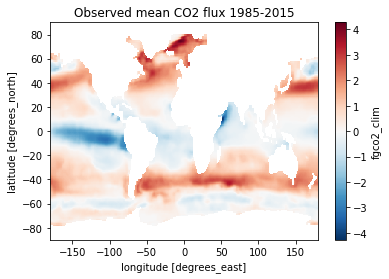

In [23]:
(fgco2_obs.mean(dim='monthclim')*-1).plot()
plt.title('Observed mean CO2 flux 1985-2015')

#### Briefly look at what the data looks like in the xarray structure.

- fgco2 is the surface CO2 flux. It is in SI units (kg / C / m2 /s2). It covers the whole globe, and extends in time from 1850 to 2014. The model resolution is about 1 degree, but it is a high non-uniform tripolar grid, known as ORCA1. The CO2 flux is positive into the ocean

- areacella is the area (m2) per grid cell. This is particularly important to know for an irregular grid, since you cannot infer it. There is aonly one time-level, since it is invariant in time.

In [24]:
def addCyclicPoint(xarray_obj, dim, period=None):
    """
    Add a cyclic longitude point for data that doesn't wrap back to zero. Avoids seam at 0 or 180 longitude
    """
    if period is None:
        period = xarray_obj.sizes[dim] * xarray_obj.coords[dim][:2].diff(dim).item()
    first_point = xarray_obj.isel({dim: slice(1)})
    first_point.coords[dim] = first_point.coords[dim]+period
                                    
    return xr.concat([xarray_obj, first_point], dim=dim)

#### Plot the spatially resolved, time average over 1981 to 2010, CO2 flux

In [25]:
# Define some constants for conversion of units
sec_2_yr = 60*60*24*365
kg_2_mol = 1000./12.
kgs_2_pgyr = sec_2_yr / 1e12

In [26]:
# Take the time average, and convert from kg/m2/s to mol/m2/yr
fgco2_1981_2010_mean = fgco2.sel(time=slice('1981', '2010')).mean(dim='time')*kg_2_mol*sec_2_yr 

# this adds a cyclic point, which prevents plotting artifacts at the overlap boundary
fgco2_1981_2010_mean_cyc = addCyclicPoint(fgco2_1981_2010_mean, dim='i') 

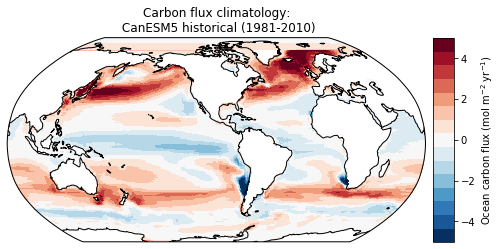

In [27]:
fig = plt.figure(figsize=(8,6))

vmin=-5
vmax=5
ncol=15

# Create a Robinson projection to plot in
axo = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=260))

cbl = axo.pcolormesh(fgco2_1981_2010_mean_cyc.longitude, fgco2_1981_2010_mean_cyc.latitude, 
                     fgco2_1981_2010_mean_cyc.fgco2, 
                     cmap=plt.cm.get_cmap('RdBu_r', ncol), vmin=vmin, vmax=vmax, 
                     rasterized=True,transform=ccrs.PlateCarree())

divider = make_axes_locatable(axo)
ax_cb = divider.append_axes('right', size="5%", pad=0.1, axes_class=plt.Axes)

_=plt.colorbar(cbl, cax=ax_cb, label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')

axo.set_title('Carbon flux climatology:\n CanESM5 historical (1981-2010)')
_=axo.coastlines()

#plt.savefig('global_ocean_carbon_flux_canesm5.png', bbox_inches='tight', dpi=300)

#### Plot the global mean CO2 flux over the full record

- Compute the global mean by weighting with the ocean grid cell areas

In [28]:
global_ocean_area = areacello.areacello.sum(dim=('i','j'))
fgco2_global_mean = (fgco2.fgco2 * areacello.areacello).sum(dim=('i','j')) / global_ocean_area 
fgco2_global_integral = (fgco2.fgco2 * areacello.areacello).sum(dim=('i','j')) * kgs_2_pgyr

Text(0.5, 1.0, 'Global ocean CO$_2$ flux in CanESM5 historical run')

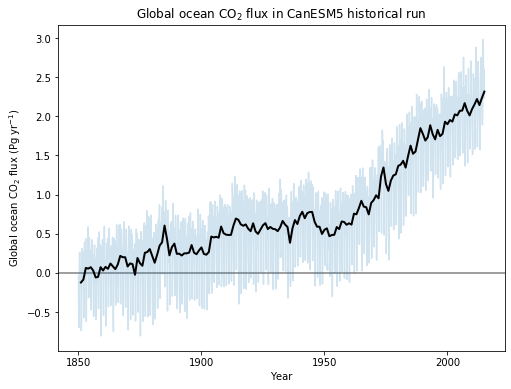

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
(fgco2_global_integral).plot(ax=ax, alpha=0.2)

# plot the annual version on top
(fgco2_global_integral.resample(time='A').mean()).plot(ax=ax, alpha=1, color='k', linewidth=2)

ax.axhline(y=0, color='k', alpha=0.5, zorder=0)
ax.set_ylabel('Global ocean CO$_2$ flux (Pg yr$^{-1}$)')
ax.set_xlabel('Year')
ax.set_title('Global ocean CO$_2$ flux in CanESM5 historical run')

# Example remap to a common 1x1 grid

In [30]:
# setup a common 1 degree global grid in xesmf
ds_out = xe.util.grid_global(1, 1)

In [36]:
# Remap the model data to the common 1x1 grid
# xESMF is fairly fussy about how dimensions are named. It is also sensitive to extra dimensions and bounds. 
# Adjust the input dataset for these.
ds = fgco2_1981_2010_mean.rename({'longitude':'lon', 'latitude':'lat'}) 

# define a regridder from the target to source grid
regridder = xe.Regridder(ds, ds_out, 'bilinear', ignore_degenerate=True, reuse_weights=True, periodic=True)

# Do the actual remapping
fgco2_1981_2010_mean_remapped = regridder(ds.fgco2) # note how dimensions change in this result

Reuse existing file: bilinear_291x360_180x360_peri.nc


In [48]:
# Remap the observed data to the common grid
ds = (fgco2_obs.mean(dim='monthclim')*-1)

# define a regridder from the target to source grid
regridder = xe.Regridder(ds, ds_out, 'bilinear', ignore_degenerate=True, reuse_weights=True, periodic=True)

# Do the actual remapping
fgco2_obs_remapped = regridder(ds)

Reuse existing file: bilinear_180x360_180x360_peri.nc


/HOME/ncs/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


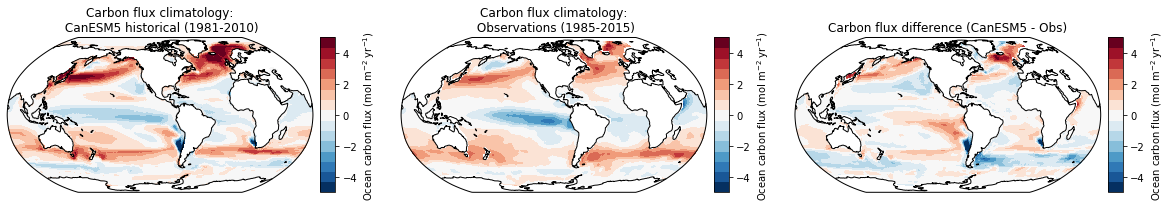

In [51]:
fig = plt.figure(figsize=(20,5))

vmin=-5
vmax=5
ncol=15

# Plot the model result
axl = plt.subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=260))

cbl = axl.pcolormesh(fgco2_1981_2010_mean_remapped.lon, fgco2_1981_2010_mean_remapped.lat, 
                     fgco2_1981_2010_mean_remapped, 
                     cmap=plt.cm.get_cmap('RdBu_r', ncol), vmin=vmin, vmax=vmax, 
                     rasterized=True,transform=ccrs.PlateCarree())

divider = make_axes_locatable(axl)
ax_cb = divider.append_axes('right', size="5%", pad=0.1, axes_class=plt.Axes)

_=plt.colorbar(cbl, cax=ax_cb, label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')

axl.set_title('Carbon flux climatology:\n CanESM5 historical (1981-2010)')
_=axl.coastlines()

# Plot the observed climatology
axm = plt.subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=260))

cbl = axm.pcolormesh(fgco2_obs_remapped.lon, fgco2_obs_remapped.lat, 
                     fgco2_obs_remapped, 
                     cmap=plt.cm.get_cmap('RdBu_r', ncol), vmin=vmin, vmax=vmax, 
                     rasterized=True,transform=ccrs.PlateCarree())

divider = make_axes_locatable(axm)
ax_cb = divider.append_axes('right', size="5%", pad=0.1, axes_class=plt.Axes)

_=plt.colorbar(cbl, cax=ax_cb, label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')

axm.set_title('Carbon flux climatology:\n Observations (1985-2015)')
_=axm.coastlines()

# Plot the model - observation difference
axm = plt.subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=260))

cbl = axm.pcolormesh(fgco2_obs_remapped.lon, fgco2_obs_remapped.lat, 
                     fgco2_1981_2010_mean_remapped - fgco2_obs_remapped, 
                     cmap=plt.cm.get_cmap('RdBu_r', ncol), vmin=vmin, vmax=vmax, 
                     rasterized=True,transform=ccrs.PlateCarree())

divider = make_axes_locatable(axm)
ax_cb = divider.append_axes('right', size="5%", pad=0.1, axes_class=plt.Axes)

_=plt.colorbar(cbl, cax=ax_cb, label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')

axm.set_title('Carbon flux difference (CanESM5 - Obs)')
_=axm.coastlines()

In [72]:
np.corrcoef(fgco2_1981_2010_mean_remapped.dropna(dim='y').dropna(dim='x').values.flatten(), 
            fgco2_obs_remapped.dropna(dim='y').dropna(dim='x').values.flatten())

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2880 and the array at index 1 has size 1440